In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Flatten, Dense, Conv1D, GlobalMaxPooling1D, LSTM, Bidirectional, Dropout, BatchNormalization, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# Data import

In [2]:
df_reddit = pd.read_csv('../data/stocknews/RedditNews.csv')
df_news = pd.read_csv('../data/stocknews/Combined_News_DJIA.csv')
df_djia = pd.read_csv('../data/stocknews/upload_DJIA_table.csv')


In [3]:
df_djia_news = pd.merge(df_djia, df_news, on='Date', how='inner')

df = pd.merge(df_djia_news, df_reddit, on='Date', how='inner')

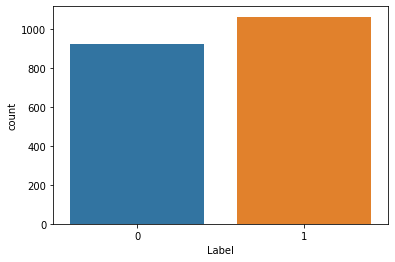

In [4]:
# 0 = decrease , 1 = increase or equal at Adj.Close
sns.countplot(x='Label', data=df_news)

In [5]:
df_news['Date'] = pd.to_datetime(df_news.Date)
train_split = 0.8
total_count = df_news.shape[0]
train_cut = int(total_count * train_split)
train = df_news.loc[:train_cut-1, :]
test = df_news.loc[train_cut:, :]
y_train = np.array(train["Label"])
y_test = np.array(test["Label"])

In [6]:
train.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

# Preprocessing

In [7]:
trainheadlines = list()
for row in range(0, len(train.index)):
    trainheadlines.append(' '.join(str(x) for x in train.iloc[row, 2:27]))
testheadlines = list()
for row in range(0, len(test.index)):
    testheadlines.append(' '.join(str(x) for x in test.iloc[row, 2:27]))
    

# RNN with Glove embedding

In [8]:
def read_glove_vecs(glove_file):
    with open (glove_file, 'r', encoding='utf-8') as f:
        words = set()
        word_to_vec_map = dict()
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
            
        i = 1
        words_to_index = dict()
        index_to_words = dict()
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i += 1
    return words_to_index, index_to_words, word_to_vec_map

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

In [9]:
os.listdir('/Users/2two2/Downloads/glove.6B')

['glove.6B.300d.txt',
 'glove.6B.100d.txt',
 'glove.6B.50d.txt',
 'glove.6B.200d.txt']

In [10]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/Users/2two2/Downloads/glove.6B/glove.6B.50d.txt')

In [11]:
word_to_vec_map['the'].shape

(50,)

In [12]:
def sentences_to_indices(X, word_to_index, max_len):
    
    m = X.shape[0]
    X_indices = np.zeros((m, max_len), dtype=np.int)
    
    for i in range(m):
        sentence_words = [w.lower() for w in X[i].split()]
        
        j = 0
        
        for w in sentence_words:
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                j += 1
                if j >= max_len:
                    break
                
    return X_indices

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map['stock'].shape[0]
    
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]
        
    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False)
    embedding_layer.build((None,))
    
    embedding_layer.set_weights([emb_matrix])
    return embedding_layer

In [13]:
strip_special_chars = re.compile("[^A-Za-z ]+")

def cleanSentences(string):
    string = string.lower().replace("b\"", " ")
    string = string.lower().replace("b\'", "")
    return re.sub(strip_special_chars, "", string.lower())
    

In [14]:
a = ['b"Georgia \'downs']
np.array(list(map(lambda x:cleanSentences(x), a)))

array([' georgia downs'], dtype='<U14')

In [15]:
X_train = np.array(list(map(lambda x:cleanSentences(x), trainheadlines)))
X_test = np.array(list(map(lambda x:cleanSentences(x), testheadlines)))

X_train[0]

' georgia downs two russian warplanes as countries move to brink of war breaking musharraf to be impeached russia today columns of troops roll into south ossetia footage from fighting youtube russian tanks are moving towards the capital of south ossetia which has reportedly been completely destroyed by georgian artillery fire  afghan children raped with impunity un official says  this is sick a three year old was raped and they do nothing  russian tanks have entered south ossetia whilst georgia shoots down two russian jets  breaking georgia invades south ossetia russia warned it would intervene on sos side  the enemy combatent trials are nothing but a sham salim haman has been sentenced to   years but will be kept longer anyway just because they feel like it georgian troops retreat from s osettain capital presumably leaving several hundred people killed video did the us prep georgia for war with russia rice gives green light for israel to attack iran says us has no veto over israeli mi

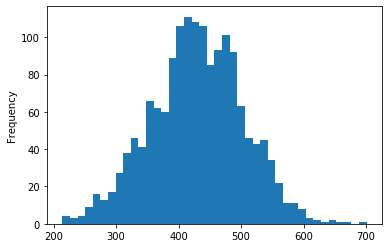

In [16]:
X_train_lengths = list(map(lambda x: len(x.split()), X_train))
df = pd.DataFrame({'counts': X_train_lengths})
df.counts.plot.hist(bins=40)

In [17]:
X1 = np.array(['germany to meet with france'])
X1_indices = sentences_to_indices(X1, word_to_index, max_len=9)
print("X1 = ", X1)
print("X1_indices = ", X1_indices)

X1 =  ['germany to meet with france']
X1_indices =  [[160180 360915 239785 388711 152927      0      0      0      0]]


In [18]:
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
embedding_layer.get_weights()[0][word_to_index['the']]

W1125 18:47:43.851996 4618571200 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow_core/python/keras/initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1125 18:47:43.885548 4618571200 deprecation.py:506] From /usr/local/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1630: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


array([ 4.1800e-01,  2.4968e-01, -4.1242e-01,  1.2170e-01,  3.4527e-01,
       -4.4457e-02, -4.9688e-01, -1.7862e-01, -6.6023e-04, -6.5660e-01,
        2.7843e-01, -1.4767e-01, -5.5677e-01,  1.4658e-01, -9.5095e-03,
        1.1658e-02,  1.0204e-01, -1.2792e-01, -8.4430e-01, -1.2181e-01,
       -1.6801e-02, -3.3279e-01, -1.5520e-01, -2.3131e-01, -1.9181e-01,
       -1.8823e+00, -7.6746e-01,  9.9051e-02, -4.2125e-01, -1.9526e-01,
        4.0071e+00, -1.8594e-01, -5.2287e-01, -3.1681e-01,  5.9213e-04,
        7.4449e-03,  1.7778e-01, -1.5897e-01,  1.2041e-02, -5.4223e-02,
       -2.9871e-01, -1.5749e-01, -3.4758e-01, -4.5637e-02, -4.4251e-01,
        1.8785e-01,  2.7849e-03, -1.8411e-01, -1.1514e-01, -7.8581e-01],
      dtype=float32)

In [19]:
print('Build model....')
model = Sequential([
    pretrained_embedding_layer(word_to_vec_map, word_to_index),
    GRU(128, dropout=0.2, return_sequences=True),
    GRU(128, dropout=0.2),
    Dense(1, activation='sigmoid')
])
model.load_weights('./embedding_model.h5')
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Build model....


W1125 18:47:46.694964 4618571200 deprecation.py:323] From /usr/local/lib/python3.6/site-packages/tensorflow_core/python/ops/nn_impl.py:183: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          20000050  
_________________________________________________________________
gru (GRU)                    (None, None, 128)         68736     
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 20,167,603
Trainable params: 167,553
Non-trainable params: 20,000,050
_________________________________________________________________


In [20]:
maxlen = 500
batch_size = 32
X_train_indices = sentences_to_indices(X_train, word_to_index, maxlen)
X_test_indices = sentences_to_indices(X_test, word_to_index, maxlen)

In [21]:
Y_train = y_train.reshape((-1, 1))
Y_test = y_test.reshape((-1, 1))

In [22]:
# print('Train...')
# history = model.fit(X_train_indices, Y_train, batch_size=batch_size, 
#                     epochs=10, validation_data=(X_test_indices, Y_test))
# model.save('./embedding_model.h5')
# score, acc = model.evaluate(X_test_indices, Y_test, 
#                            batch_size=batch_size)
# print('Test score: ', score)
# print('Test accuracy: ', acc)


In [32]:
y_pred_keras = model.predict(X_test_indices).ravel()
fpr_keras, tpr_keras, threshold_keras = roc_curve(y_test, y_pred_keras)

In [33]:
auc_keras = auc(fpr_keras, tpr_keras)

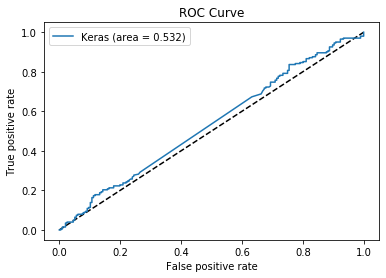

In [34]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label="Keras (area = {:.3f})".format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [31]:
y_pred_keras[0]

0.045601815

In [30]:
X_test[0]

'british man found with nailbomb weapons cache and plans to mass murder immigrants not charged with terrorism israel must give up nuclear weapons united nations resolution ukraine pm discloses accident at nuclear plant reuters russian state tvs latest attempt to persuade viewers of the moral depravity of the west has left it with egg on its face what it presented as a child in the usa being exposed to lewd homoerotica was quickly shown to be a fake pornographic parody taken off the internet dna confirms king richard iiis remains under parking lot an indian state has halted mass sterilisations at health clinics after a doctor was found using a bicycle pump to inflate womens abdomens north korea bans name jongun for all but leader south korean government officials said on wednesday that north korea had banned parents from giving their newborns the same name as the top leader people who already have the name have been ordered to register with new ones president bashar al assad of syria sa